#Tweet Sentiment Extraction#

##Problem Statement:##

  With all of the tweets circulating every second it is hard to tell whether the sentiment 
behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or 
devastate profit because it strikes a negative tone. Capturing sentiment in language is important 
in these times where decisions and reactions are created and updated in seconds. But, which 
words actually lead to the sentiment description? In this competition we will need to pick out the 
part of the tweet (word or phrase) that reflects the sentiment. The main objective of this study is 
to figure out which phrase or word determines the sentiment of the tweet.
  

##Metric:##
Jaccard Score. As we need to find the correct selected text we shall use jaccard score 
which calculates intersection over union. This metric is suggested by kaggle.

##Code##

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 132MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/tweet-sentiment-extraction.zip', 'r') as zipref:
  zipref.extract('train.csv')
  zipref.extract('test.csv')
  zipref.extract('sample_submission.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_data=pd.read_csv('/content/train.csv')

In [ ]:
train_data.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


##Exploratory Data Analysis##

In [ ]:
train_data.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [ ]:
print("Missing values:\n",train_data.isna().sum())

Missing values:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


Here there is one data point with missing values. So we will delete the missing data.

In [ ]:
print(train_data.shape)
train_data.dropna(inplace=True)
print(train_data.shape)

(27481, 4)
(27480, 4)


####Distribution of sentiments####

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


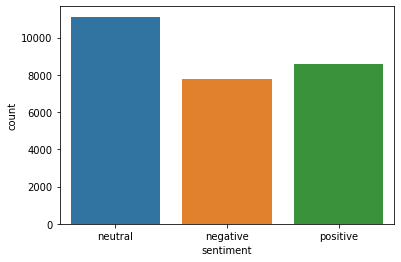

In [ ]:
sns.countplot('sentiment',data=train_data)

We can see that neutral sentences are higher in than the positive and negative sentences. Now lets deep dive into analysis of these sentences.

Before Going to preprocessing we need to do certain analysis on the selected texts(i.e output). This is because usually in preprocessing we will remove stopwords, punctuations, URLS etc. But here if we observe some of the selected text have punctuation, URL. So it is necessary to find whether do we need to have punctuations, URL and so on.

In [ ]:
#NWT-Number of Words in Text
train_data['NWT']=train_data['text'].apply(lambda x:len(str(x).split()))
#NWST-Number of Words in Selected Text
train_data['NWST']=train_data['selected_text'].apply(lambda x:len(str(x).split()))
#NDW-Number of Differing Words between text and selected text
train_data['NDW']=train_data['NWT']-train_data['NWST']

In [ ]:
import re
def no_url(string):
  urls=re.findall(r'(https?://[^\s]+)', string)
  return len(urls)

In [ ]:
#Number of URL in text
train_data['number_of_url']=train_data['text'].apply(lambda x:no_url(x))
#Number of URL in selected text
train_data['number_of_url_st']=train_data['selected_text'].apply(lambda x:no_url(x))

In [ ]:
def is_spl_char(string):
  if len(re.findall('[^A-Za-z]+',string))>=2:
    return 1
  else:
    return 0

In [ ]:
# Here spl_char represents the punctuations like *,!,_ etc.
train_data['is_spl_char_st']=train_data['selected_text'].apply(lambda x:is_spl_char(x))

In [ ]:
train_data.head()

,textID,text,selected_text,sentiment,NWT,NWST,NDW,number_of_url,number_of_url_st,is_spl_char_st
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,0,0,0,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,8,0,0,0
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,3,0,0,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3,2,0,0,1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,11,0,0,1


####Number of urls analysis####

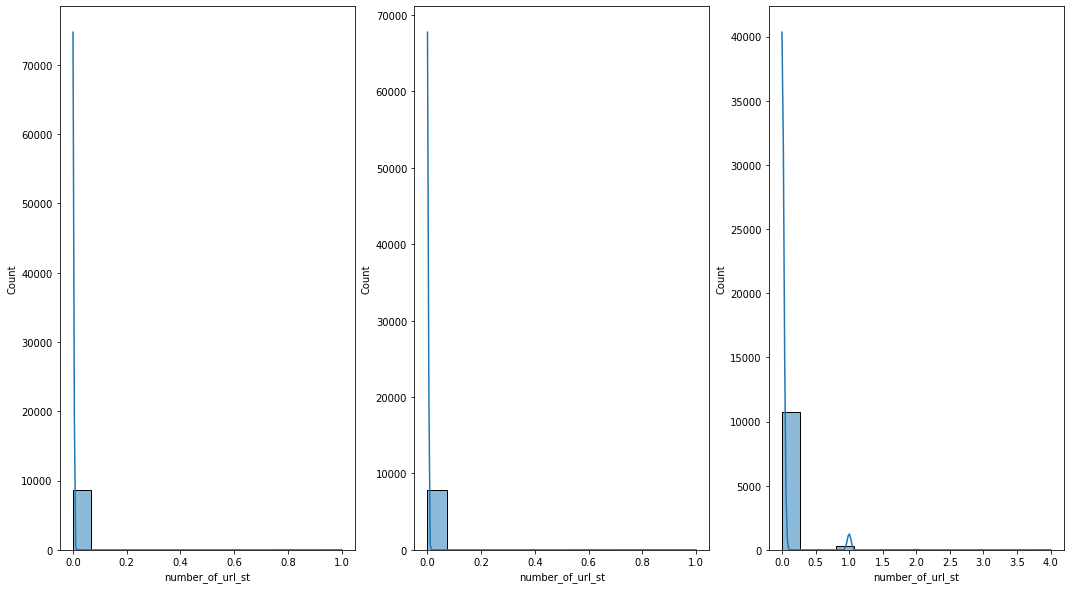

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
sns.histplot(ax=axes[0],data=train_data[train_data['sentiment']=='positive'],x='number_of_url_st',kde=True)
sns.histplot(ax=axes[1],data=train_data[train_data['sentiment']=='negative'],x='number_of_url_st',kde=True)
sns.histplot(ax=axes[2],data=train_data[train_data['sentiment']=='neutral'],x='number_of_url_st',kde=True)

This graph shows number of urls in selected text(i.e output) for each of the positive, negative and neutral sentiments. We can see that for both positive and negative sentences we don't have any URL but for neutral sentences there are certain data that have URL.

####Special characters in selected text Analysis####

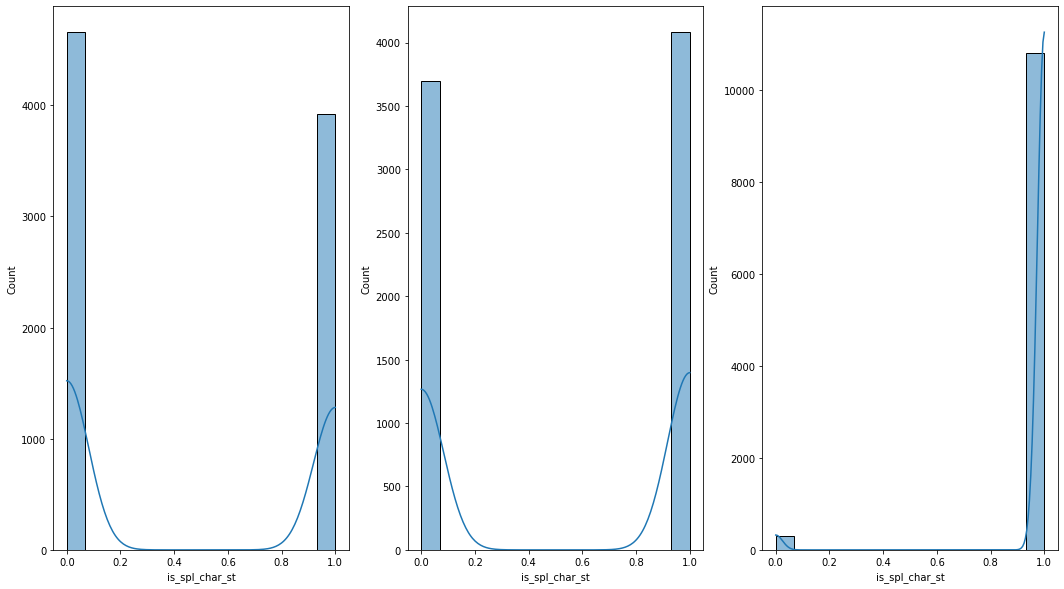

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
sns.histplot(ax=axes[0],data=train_data[train_data['sentiment']=='positive'],x='is_spl_char_st',kde=True)
sns.histplot(ax=axes[1],data=train_data[train_data['sentiment']=='negative'],x='is_spl_char_st',kde=True)
sns.histplot(ax=axes[2],data=train_data[train_data['sentiment']=='neutral'],x='is_spl_char_st',kde=True)

From the above graph we can see that punctuations have a resonable presence in the selected text for all sentiments.

####Analysis on positive sentiments####

In [ ]:
train_data['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

Text(0.5, 1.0, 'Distribution of number of words in positive texts')

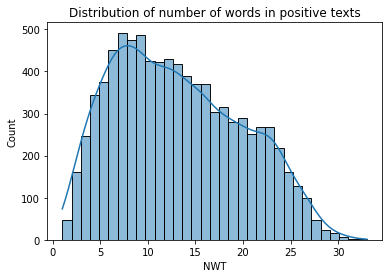

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='positive'],x='NWT',kde=True).set_title('Distribution of number of words in positive texts')

The above graph shows the how number of dataset having how number of words in the text.

Text(0.5, 1.0, 'Distribution of number of words in positive selected text')

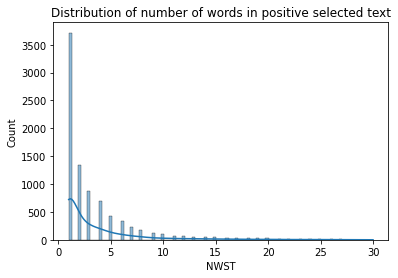

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='positive'],x='NWST',kde=True).set_title('Distribution of number of words in positive selected text')

The above graph shows number of words present in selected text corpus. We can see that more than 3500 data have just one word as selected text and almost many of the corpus have have less than 5 to 6 words as their selected text.

Text(0.5, 1.0, 'Distribution of number of differing words for positive texts')

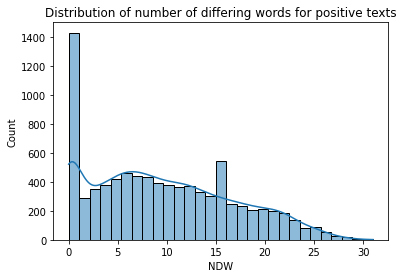

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='positive'],x='NDW',kde=True).set_title('Distribution of number of differing words for positive texts')

Number of differing words represents the number of words in text that are not in selected text. We can observe that there are almost 1400 dataset where only one word in text is not there in selected text. Also there are lot of dataset where many words in text is not present in selected dataset.

In [ ]:
positive_data=train_data[train_data['sentiment']=='positive']

####Analysis on negative sentences####

Text(0.5, 1.0, 'Distribution of number of words in negative texts')

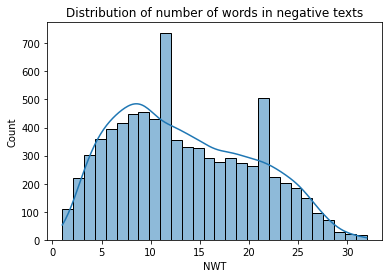

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='negative'],x='NWT',kde=True).set_title('Distribution of number of words in negative texts')

From the above histogram we can see that there are majority(ie nearly 700) of sentences which have 11 words. 

Text(0.5, 1.0, 'Distribution of number of words in negative selected text')

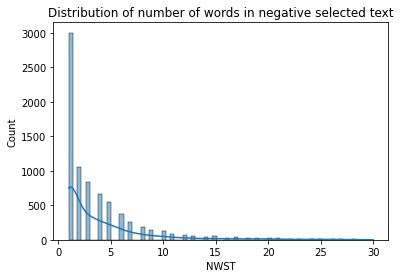

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='negative'],x='NWST',kde=True).set_title('Distribution of number of words in negative selected text')

Similar to positive texts we can observe that majority of selected text have 1 word as their selceted text and almost many dataset have fewer than 10 words as their selected text.

Text(0.5, 1.0, 'Distribution of number of differing words for negative texts')

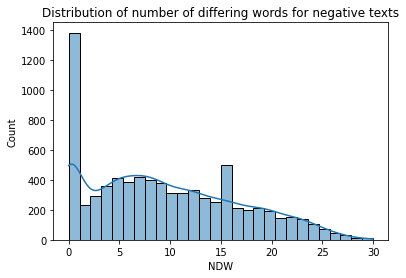

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='negative'],x='NDW',kde=True).set_title('Distribution of number of differing words for negative texts')

This is similar to the distribution of the positive text where majority have 1 word in text that are not in selected text.

####Analysis on neutral sentences####

Text(0.5, 1.0, 'Distribution of number of words in neutral texts')

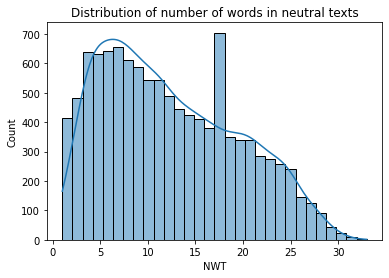

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='neutral'],x='NWT',kde=True).set_title('Distribution of number of words in neutral texts')

Text(0.5, 1.0, 'Distribution of number of words in neutral selected text')

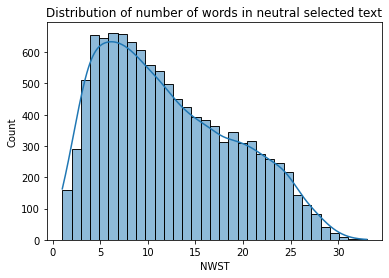

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='neutral'],x='NWST',kde=True).set_title('Distribution of number of words in neutral selected text')

Unlike the posititve and negative sentences we can see that for neutral sentences the selected text contains a lot of words and also if we observe the above graph and this graph is almost same. This shows that the text for neutral sentences is same as selected text.

Text(0.5, 1.0, 'Distribution of number of differing words for neutral texts')

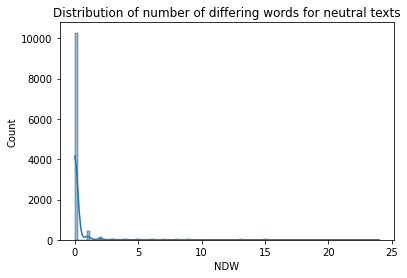

In [ ]:
sns.histplot(data=train_data[train_data['sentiment']=='neutral'],x='NDW',kde=True,bins=100).set_title('Distribution of number of differing words for neutral texts')

This graph shows that for neutral sentences the seleceted text is same as the text except for very few sentences.

From the above analysis here I will be modelling positive and negative sentences alone wherelse for neutral sentences the seleceted text will be the same as the text. Logically this would be correct because there are no words to confirm that the given sentence is neutral unlike positive and negative sentences which have words like good,love,like,hate,curse and so on. 

##Preprocessing##

In [ ]:
from bs4 import BeautifulSoup
import re
def preprocess(sentence):
    sentence=sentence.replace('****',"curse")# changing bad words(marked as **** in text) to 'curse'
    sentence=' '.join(e.lower() for e in sentence.split())
    return sentence.strip()    

In [ ]:
train_data['preprocessed_texts']=train_data['text'].apply(lambda x: preprocess(x))
train_data['preprocessed_sel_texts']=train_data['selected_text'].apply(lambda x: preprocess(x))

Now we need to output for training the model. Here our output would be in the form of array with values 1 and 0. The array will be of length of the maximum length of the sentences and value 1 will be assigned to the particular index position for which that particular text is in selecetd text.

eg: 

text: He is a good boy.

selected text: good boy

Output_array: [0,0,0,1,1]

To start with it is necessary to exract the index position of the words. There were lot of complications in extracting it.

eg:

text: This is awesome

selected text: s awesome


text: pod...sad...i have

selected text ..sad

Below code is used to run these complications.

In [ ]:
import re
def crct_start_ind_1(x):
  '''
  This function is used to retrive the text wherein the selected text is have few first words and rest missing in the real text.
  Eg: Text: Jealously
      Selceted text: Jealous
  Returns: Jealously
      In this case the function returns the word Jealously beacause with the exact word we can find the index position in the text.

                                              (OR)
                                          
      Text: gonna
      Selected text: onna
  Returns: gonna
  '''
  tex=x[0]#List of words in text
  sel_word=x[1]#string: selected text
  len_sel_word=len(sel_word)
  for wrd in tex:
    if sel_word == wrd[:len_sel_word]:# This finds the words like Jealous 
      wrd_in_tex=wrd
      break
    elif sel_word == wrd[-len_sel_word:]:# This finds for the words like onna
      wrd_in_tex=wrd
      break
  return wrd_in_tex

def crct_start_ind_2(x):
  """
  This function is used to retrive the text wherein the selected text has words in between the words in the text.
  eg: Text: pod...sad...i
      Selected text: ..sad

  returns: pod...sad..i

  """
  tex=x[0]
  sel_word=x[1]
  for wrd in tex:
    if re.search(sel_word,wrd) != None:
      wrd_in_tex=wrd
      break
  return wrd_in_tex

In [ ]:
def start_indices(x):
    text_str=x[0]
    sel_text_str=x[1]
    prepro_text=x[2]
    text_list=text_str.split()#splitting the text
    sel_text_list=sel_text_str.split()#spliting selected text
    prepro_text_list=prepro_text.split()#spliting preprocessed text #no need
    end=sel_text_list[0]
    try:
      #Finds whether the first word of selected text is in text.
      index=text_list.index(end)
    except:
      if len(sel_text_list)==1:
        try:
          #if the 1st word is not in selected text and number of words in selected text is 1 then find the word using the crct_start_ind_1 function     
          end_new=crct_start_ind_1((text_list,end))
          index=text_list.index(end_new)
        except:
          #There are some words like in text 'pod...sad...i' but selected text it is '..sad'. The number of abnormal data like these are 15 data points. We can neglect those data points and give them the index value 0.
          index=0
      else:
        try:
          #There are some words like in the text 'this awesome' but selected text it is 's awesome'. Here we neglect those 's' and start from the other word.
          end=sel_text_list[1]
          index=text_list.index(end)
        except:
          #There are some words like in the text 'this awesome' but selected text it is 's awes'. Here we neglect 's' and take 'awes' and retrive 'awesome' from original text.
          end_new=crct_start_ind_1((text_list,end))
          index=text_list.index(end_new)
    return index
def end_indices(x):
    text_str=x[0]
    sel_text_str=x[1]
    start_indices=x[2]
    text_list = text_str.split()
    sel_text_list = sel_text_str.split()
    end = sel_text_list[-1]
    try:
        #if the end word is in the text in then we directly retrive the index of that word and declare it as end index
        index = text_list.index(end,start_indices)
    except:
        #if the end word is not proper then we obtain the end index by adding the length of the words in selected text to the starting index to get the exactl end index
        index = start_indices+(len(sel_text_list)-1)
    return index


In [ ]:
train_data['start_index']=train_data[['text','selected_text','preprocessed_texts']].apply(lambda x: start_indices(x),axis=1)
train_data['end_index']=train_data[['text','selected_text','start_index']].apply(lambda x: end_indices(x),axis=1)

In [ ]:
complete_data=train_data[['text','selected_text','preprocessed_texts','sentiment','start_index','end_index']]

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(complete_data,stratify=complete_data['sentiment'],test_size=0.2,random_state=42)

In [ ]:
print(train.shape)
print(test.shape)

(21984, 6)
(5496, 6)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train.to_csv('/content/drive/MyDrive/case_study_2_new/train_pos_neg_neu.csv')
test.to_csv('/content/drive/MyDrive/case_study_2_new/test_pos_neg_neu.csv')

In [ ]:
train

,text,selected_text,preprocessed_texts,sentiment,start_index,end_index
16595,Press `Ctrl` on bottom right. It`s there. KY,Press `Ctrl` on bottom right. It`s there. KY,press `ctrl` on bottom right. it`s there. ky,neutral,0,7
15039,ah remember the days when you`d sleep in until...,loser,ah remember the days when you`d sleep in until...,negative,21,21
1804,my momma is comin 2night ! 2morrow tennis day...,yuppie,my momma is comin 2night ! 2morrow tennis day ...,positive,11,11
7302,I do that all the time,I do that all the time,i do that all the time,neutral,0,5
27217,We don`t feel too comfortable using it. It`s...,". It`s not awful, but pretty icky",we don`t feel too comfortable using it. it`s n...,negative,7,13
...,...,...,...,...,...,...
25183,"Should be drank with sugar and milk, not coff...","Should be drank with sugar and milk, not coffe...","should be drank with sugar and milk, not coffe...",neutral,0,14
7595,Thinks she`s getting sick.....,Thinks she`s getting sick.....,thinks she`s getting sick.....,negative,0,3
16318,"Get Up, You are NOT old! What did you do?! =O","Get Up, You are NOT old! What did you do?! =O","get up, you are not old! what did you do?! =o",neutral,0,10
7399,Ha Ha thanks Tom! I`m such a loser! Hopefully...,Ha Ha thanks Tom! I`m such a loser! Hopefully ...,ha ha thanks tom! i`m such a loser! hopefully ...,neutral,0,23


In [ ]:
X_train=train
X_test=test

In [ ]:
sent_len=[]
for i in X_train['preprocessed_texts']:
  sent_len.append(len(i.split()))

In [ ]:
max_sent_len=max(sent_len)

In [ ]:
print(max_sent_len)

33


Here the maximum length of the sentence is 33.

In [ ]:
train_data=train_data.reset_index(drop=True)

In [ ]:
X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)

Now let's create the output array with the start and end index that has been defined.

In [ ]:
y_train=np.zeros((len(X_train),max_sent_len))
for i in range(len(X_train)):
  s_ind=X_train['start_index'][i]
  e_ind=X_train['end_index'][i]
  y_train[i][s_ind:e_ind+1]=1

y_test=np.zeros((len(X_test),max_sent_len))
for i in range(len(X_test)):
  s_ind=X_test['start_index'][i]
  e_ind=X_test['end_index'][i]
  y_test[i][s_ind:e_ind+1]=1

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(21984, 6)
(21984, 33)
(5496, 6)
(5496, 33)


#####Tokenizing text#####

Now let's tokenizer the given text.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer_text = Tokenizer(lower=True,split=' ',oov_token='oov',filters='')
tokenizer_text.fit_on_texts(X_train['preprocessed_texts'])
train_text=tokenizer_text.texts_to_sequences(X_train['preprocessed_texts'])
test_text=tokenizer_text.texts_to_sequences(X_test['preprocessed_texts'])
print(len(train_text),len(test_text))
vocab_size_text=len(tokenizer_text.word_index)+1
print(vocab_size_text)

21984 5496
38689


In [ ]:
len_of_texts=[]
for i in range(len(train_text)):
  len_of_texts.append(len(train_text[i]))
max_length=max(len_of_texts)
print("Maximum length is ",max_length)

Maximum length is  33


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_text = pad_sequences(train_text,maxlen=max_length,padding='post')
test_text = pad_sequences(test_text,maxlen=max_length,padding='post')
print(train_text.shape,test_text.shape)

(21984, 33) (5496, 33)


Importing the Glove Vectors for embedding

In [ ]:
!wget --header="Host: cdn-lfs.huggingface.co" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,ta;q=0.8" --header="Referer: https://github.com/stanfordnlp/GloVe" --header="Cookie: _ga=GA1.2.886028711.1663479450" --header="Connection: keep-alive" "https://cdn-lfs.huggingface.co/stanfordnlp/glove/3123e7f5c3f6a30095d413b12fc3284bbf717acd2a9bed63d1c7c13bf5223352?response-content-disposition=attachment%3B%20filename%3D%22glove.twitter.27B.zip%22&Expires=1666803394&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzMxMjNlN2Y1YzNmNmEzMDA5NWQ0MTNiMTJmYzMyODRiYmY3MTdhY2QyYTliZWQ2M2QxYzdjMTNiZjUyMjMzNTI~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj1hdHRhY2htZW50JTNCJTIwZmlsZW5hbWUlM0QlMjJnbG92ZS50d2l0dGVyLjI3Qi56aXAlMjIiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2NjY4MDMzOTR9fX1dfQ__&Signature=YfgTlEOy-Ec0PuSQg-iGmEZnZFs8eiYOkWOhVwxhZViRc~JWVKxJK9alQGY5a~G9PZsJsNuBsEtyqJHxAnp~aeJYsQ9O114HL0t9eDGFBkFyGFt1Hux93jyzTpx0sEV-Ik2aw27T1oLEF-YOUFbtOpMHAs~Piotm4Kw5VWos1UsDgI4dkFIThbA6bCuQa9UJWA4WYwB7HTrwMDmvo7Ov3HEUhlh5odZYL6~Qvv8Vrpo1SyoqSujctySm7QuOEbif2zvh-eZCILadoUgunkCDEBRCQ9W6bDYzzj4d7uXA10nuZfb9ewN9wb8N2PALtTGDCBrlBUMhpEDcgRomcTxdIw__&Key-Pair-Id=KVTP0A1DKRTAX" -c -O 'glove.twitter.27B.zip'

--2022-10-26 06:13:24--  https://cdn-lfs.huggingface.co/stanfordnlp/glove/3123e7f5c3f6a30095d413b12fc3284bbf717acd2a9bed63d1c7c13bf5223352?response-content-disposition=attachment%3B%20filename%3D%22glove.twitter.27B.zip%22&Expires=1666803394&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzMxMjNlN2Y1YzNmNmEzMDA5NWQ0MTNiMTJmYzMyODRiYmY3MTdhY2QyYTliZWQ2M2QxYzdjMTNiZjUyMjMzNTI~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj1hdHRhY2htZW50JTNCJTIwZmlsZW5hbWUlM0QlMjJnbG92ZS50d2l0dGVyLjI3Qi56aXAlMjIiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2NjY4MDMzOTR9fX1dfQ__&Signature=YfgTlEOy-Ec0PuSQg-iGmEZnZFs8eiYOkWOhVwxhZViRc~JWVKxJK9alQGY5a~G9PZsJsNuBsEtyqJHxAnp~aeJYsQ9O114HL0t9eDGFBkFyGFt1Hux93jyzTpx0sEV-Ik2aw27T1oLEF-YOUFbtOpMHAs~Piotm4Kw5VWos1UsDgI4dkFIThbA6bCuQa9UJWA4WYwB7HTrwMDmvo7Ov3HEUhlh5odZYL6~Qvv8Vrpo1SyoqSujctySm7QuOEbif2zvh-eZCILadoUgunkCDEBRCQ9W6bDYzzj4d7uXA10nuZfb9ewN9wb8N2PALtTGDCBrlBUMhpEDcgRomcTxdIw__&Key-Pair-Id

In [ ]:
import zipfile
with zipfile.ZipFile('/content/glove.twitter.27B.zip', 'r') as zipref:
  zipref.extractall('/content/')
  zipref.close()

In [ ]:
embeddings_index = dict()
f = open('/content/glove.twitter.27B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193515 word vectors.


In [ ]:
len(embeddings_index['fan'])

200

The embedding matrix is a 200 dimensional matrix.

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size_text, 200))
for word, i in tokenizer_text.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
len(embedding_matrix)

38689

In [ ]:
tokenizer_sentiment = Tokenizer(lower=True,split=' ',oov_token='oov')
tokenizer_sentiment.fit_on_texts(X_train['sentiment'])
train_sentiment=tokenizer_sentiment.texts_to_sequences(X_train['sentiment'])
test_sentiment=tokenizer_sentiment.texts_to_sequences(X_test['sentiment'])
print(len(train_sentiment),len(test_sentiment))
vocab_size_sentiment=len(tokenizer_sentiment.word_index)+1
print(vocab_size_sentiment)

21984 5496
5


In [ ]:
tokenizer_sentiment.word_index

{'oov': 1, 'neutral': 2, 'positive': 3, 'negative': 4}

In [ ]:
len_of_sentiment=[]
for i in range(len(train_sentiment)):
  len_of_sentiment.append(len(train_sentiment[i]))
max_length_sentiment=max(len_of_sentiment)
print("Maximum length for sentiment is ",max_length_sentiment)

Maximum length for sentiment is  1


In [ ]:
embedding_matrix_sentiment = np.zeros((vocab_size_sentiment, 200))
for word, i in tokenizer_sentiment.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix_sentiment[i] = embedding_vector

In [ ]:
len(embedding_matrix_sentiment)

5

In [ ]:
max_length

33

##Modelling##

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input,Embedding,GRU,Dense,Flatten,Concatenate,Dropout,LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model

tf.keras.backend.clear_session()
input1=Input(shape=(max_length,),name='input_text')
embed = Embedding(vocab_size_text,200,input_length=max_length,name='embedding',
                      trainable=False,weights=[embedding_matrix])(input1)

input2=Input(shape=(max_length_sentiment,),name='input_sentiment')
embed2=Embedding(vocab_size_sentiment,200,input_length=max_length_sentiment,trainable=False,
                 weights=[embedding_matrix_sentiment],name='embedding_sentiment')(input2)
concat1=Concatenate(axis=1)([embed,embed2])
gru_1=GRU(100,name='GRU_1',return_sequences=True)(concat1)
gru_2=GRU(32,name='GRU_2',return_sequences=True)(gru_1)
gru_3=GRU(16,name='GRU_3',return_sequences=True)(gru_2)
f1=Flatten()(gru_3)

f1=tf.expand_dims(f1,1)
dense2=Dense(256,activation='relu',kernel_regularizer=l2(0.0001))(f1)
drop1 = Dropout(0.2)(dense2)
ln1= LayerNormalization()(drop1)
dense3=Dense(128,activation='relu',kernel_regularizer=l2(0.0001))(ln1)
drop2 = Dropout(0.2)(dense3)
ln2= LayerNormalization()(drop2)
dense4=Dense(64,activation='relu',kernel_regularizer=l2(0.0001))(ln1)
output=Dense(33,activation='sigmoid',name='output')(dense4)

model=Model(inputs=[input1,input2],outputs=[output])


In [ ]:
model1=Model(inputs=[input1,input2],outputs=[output])

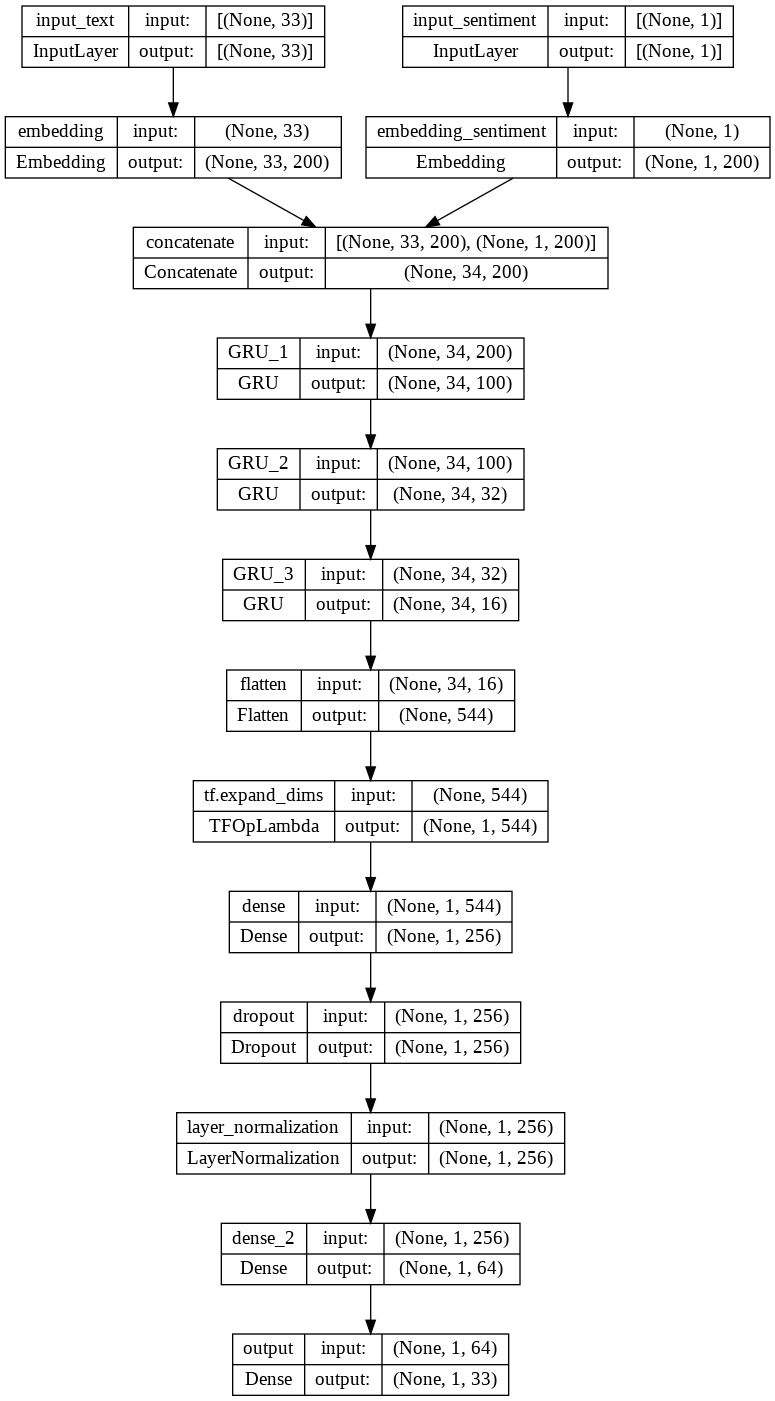

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-r8mbd3jc
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-r8mbd3jc
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 7.0 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=40f7011bde749902dbfc169f5b2eb8bcbc059b8d539da856f9ad7dc5a65a3ebc
  Stored in directory: /tmp/pip-ephem-wheel-cache-6tw89nl8/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
%load_ext tensorboard
tf.config.run_functions_eagerly(True)
import datetime
import os
import segmentation_models as sm
import math
from tensorflow.keras.callbacks import LearningRateScheduler
'''
def step_decay(epoch):
	initial_lrate = 0.0001
	drop = 0.1
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)
'''

focal_loss=sm.losses.DiceLoss(per_image=True)
iou_score=sm.metrics.IOUScore(threshold=0.5)

log_dir= "/content/drive/MyDrive/case_study_2_new/base_model_TBlog1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
callbacks=[tensorboard_callback,
          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,verbose=1,mode='min',min_lr=0.00001),
					tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/case_study_2_new/base_model_modelckpt1',monitor='val_loss',verbose=1,
					                                   save_best_only=True,save_weights_only=True)
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=focal_loss,metrics=[iou_score])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
train_input=(np.array(train_text),np.array(train_sentiment))
train_output=y_train[:,np.newaxis,:]
test_input=(np.array(test_text),np.array(test_sentiment))
test_output=y_test[:,np.newaxis,:]
validation=(test_input,test_output)
model.fit(train_input,
          train_output,epochs=40,
          validation_data=validation,callbacks=callbacks)

Epoch 1/40
687/687 [==============================] - ETA: 0s - loss: 0.4070 - iou_score: 0.5193
Epoch 1: val_loss improved from inf to 0.36999, saving model to /content/drive/MyDrive/case_study_2_new/base_model_modelckpt1
687/687 [==============================] - 56s 81ms/step - loss: 0.4070 - iou_score: 0.5193 - val_loss: 0.3700 - val_iou_score: 0.5404 - lr: 0.0010
Epoch 2/40
687/687 [==============================] - ETA: 0s - loss: 0.3744 - iou_score: 0.5351
Epoch 2: val_loss improved from 0.36999 to 0.36246, saving model to /content/drive/MyDrive/case_study_2_new/base_model_modelckpt1
687/687 [==============================] - 55s 80ms/step - loss: 0.3744 - iou_score: 0.5351 - val_loss: 0.3625 - val_iou_score: 0.5415 - lr: 0.0010
Epoch 3/40
687/687 [==============================] - ETA: 0s - loss: 0.3691 - iou_score: 0.5363
Epoch 3: val_loss did not improve from 0.36246
687/687 [==============================] - 50s 73ms/step - loss: 0.3691 - iou_score: 0.5363 - val_loss: 0.3630

In [ ]:
model.save('/content/drive/MyDrive/case_study_2_new/base_model_weights/dl_model.h5')

In [ ]:
model1.load_weights('/content/drive/MyDrive/case_study_2_new/base_model_weights/dl_model.h5')

In [ ]:
X_train[['text','selected_text','start_index','end_index']]

,text,selected_text,start_index,end_index
0,Press `Ctrl` on bottom right. It`s there. KY,Press `Ctrl` on bottom right. It`s there. KY,0,7
1,ah remember the days when you`d sleep in until...,loser,21,21
2,my momma is comin 2night ! 2morrow tennis day...,yuppie,11,11
3,I do that all the time,I do that all the time,0,5
4,We don`t feel too comfortable using it. It`s...,". It`s not awful, but pretty icky",7,13
...,...,...,...,...
21979,"Should be drank with sugar and milk, not coff...","Should be drank with sugar and milk, not coffe...",0,14
21980,Thinks she`s getting sick.....,Thinks she`s getting sick.....,0,3
21981,"Get Up, You are NOT old! What did you do?! =O","Get Up, You are NOT old! What did you do?! =O",0,10
21982,Ha Ha thanks Tom! I`m such a loser! Hopefully...,Ha Ha thanks Tom! I`m such a loser! Hopefully ...,0,23


###Saving necessary files###

In [ ]:
import joblib
joblib.dump(tokenizer_text,'/content/drive/MyDrive/case_study_2_new/base_model_tokenizer/tokenizer_text.pkl')
joblib.dump(tokenizer_sentiment,'/content/drive/MyDrive/case_study_2_new/base_model_tokenizer/tokenizer_sentiment.pkl')

['/content/drive/MyDrive/case_study_2_new/base_model_tokenizer/tokenizer_sentiment.pkl']

In [ ]:
import joblib
tokenizer_text=joblib.load('/content/drive/MyDrive/case_study_2_new/base_model_tokenizer/tokenizer_text.pkl')
tokenizer_sentiment=joblib.load('/content/drive/MyDrive/case_study_2_new/base_model_tokenizer/tokenizer_sentiment.pkl')

###Jaccard score###

In [ ]:
train_prediction=model.predict((np.array(train_text),np.array(train_sentiment)))
test_prediction=model.predict((np.array(test_text),np.array(test_sentiment)))

172/172 [==============================] - 4s 21ms/step


In [ ]:
tr_p=np.squeeze(train_prediction,1)
te_p=np.squeeze(test_prediction,1)

In [ ]:
tr_p.shape

(21984, 33)

In [ ]:
def prob_to_binary(x,threshold=0.5):
  lst=[]
  for i in x:
    if i>=threshold:
      lst.append(1)
    else:
      lst.append(0)
  return lst

In [ ]:
tr_pred=[]
for j in tr_p:
  tr_pred.append(prob_to_binary(j))
tr_pred=np.array(tr_pred)

In [ ]:
te_pred=[]
for j in te_p:
  te_pred.append(prob_to_binary(j))
te_pred=np.array(te_pred)

In [ ]:
def pred_text(x):
    pred_array=x[0]
    text=x[1]
    text_list=x[1].split()
    max_len_list=len(text_list)
    indices=np.where(pred_array==1)[0]
    indices=[ind for ind in indices if ind<max_len_list]
    pred_text_list=np.array(text_list)[indices]
    pred_text=' '.join(pred_text_list)
    return pred_text

In [ ]:
train_pred_text=[]
for i in range(len(tr_pred)):
  txt=X_train['text'].iloc[i]
  pred_arr=tr_pred[i]
  pred_txt=pred_text((pred_arr,txt))
  train_pred_text.append(pred_txt)

In [ ]:
test_pred_text=[]
for i in range(len(te_pred)):
  txt=X_test['text'].iloc[i]
  pred_arr=te_pred[i]
  pred_txt=pred_text((pred_arr,txt))
  test_pred_text.append(pred_txt)

In [ ]:
X_train['pred_text']=train_pred_text
X_test['pred_text']=test_pred_text

In [ ]:
def jaccard(x):
    str1=x[0]
    str2=x[1] 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0):
        return 0.5
    c = a.intersection(b)
    
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
X_train

,text,selected_text,preprocessed_texts,sentiment,start_index,end_index,pred_text
0,Press `Ctrl` on bottom right. It`s there. KY,Press `Ctrl` on bottom right. It`s there. KY,press `ctrl` on bottom right. it`s there. ky,neutral,0,7,Press `Ctrl` on bottom right. It`s there. KY
1,ah remember the days when you`d sleep in until...,loser,ah remember the days when you`d sleep in until...,negative,21,21,ah remember god i feel like a loser
2,my momma is comin 2night ! 2morrow tennis day...,yuppie,my momma is comin 2night ! 2morrow tennis day ...,positive,11,11,my momma p?nar yuppie !
3,I do that all the time,I do that all the time,i do that all the time,neutral,0,5,I do that all the time
4,We don`t feel too comfortable using it. It`s...,". It`s not awful, but pretty icky",we don`t feel too comfortable using it. it`s n...,negative,7,13,"We don`t not awful, but pretty icky. Scurrying"
...,...,...,...,...,...,...,...
21979,"Should be drank with sugar and milk, not coff...","Should be drank with sugar and milk, not coffe...","should be drank with sugar and milk, not coffe...",neutral,0,14,"Should be drank with sugar and milk, not coffe..."
21980,Thinks she`s getting sick.....,Thinks she`s getting sick.....,thinks she`s getting sick.....,negative,0,3,Thinks she`s getting sick.....
21981,"Get Up, You are NOT old! What did you do?! =O","Get Up, You are NOT old! What did you do?! =O","get up, you are not old! what did you do?! =o",neutral,0,10,"Get Up, You are NOT old! What did you do?! =O"
21982,Ha Ha thanks Tom! I`m such a loser! Hopefully...,Ha Ha thanks Tom! I`m such a loser! Hopefully ...,ha ha thanks tom! i`m such a loser! hopefully ...,neutral,0,23,Ha Ha thanks Tom! I`m such a loser! Hopefully ...


In [ ]:
X_train['jaccard_score']=X_train[['selected_text','pred_text']].apply(lambda x: jaccard(x),axis=1)

In [ ]:
X_test['jaccard_score']=X_test[['selected_text','pred_text']].apply(lambda x: jaccard(x),axis=1)

In [ ]:
jacc_pos_neg_train=X_train[X_train['sentiment']!='neutral']['jaccard_score']
jacc_pos_neg_test=X_test[X_test['sentiment']!='neutral']['jaccard_score']
print('Jaccard score of positive and negative sentences for train data:',np.array(jacc_pos_neg_train).mean())
print('Jaccard score of positive and negative sentences for test data:',np.array(jacc_pos_neg_test).mean())


Jaccard score of positive and negative sentences for train data: 0.4170387329309261
Jaccard score of positive and negative sentences for test data: 0.35966433494944866


In [ ]:
jacc_neut_train=X_train[X_train['sentiment']=='neutral']['jaccard_score']
jacc_neut_test=X_test[X_test['sentiment']=='neutral']['jaccard_score']
print('Jaccard score of neutral sentences for train data:',np.array(jacc_neut_train).mean())
print('Jaccard score of neutral sentences for test data:',np.array(jacc_neut_test).mean())

Jaccard score of neutral sentences for train data: 0.9594261469409443
Jaccard score of neutral sentences for test data: 0.9623107955588975


In [ ]:
print("Overall Train Jaccard Score",np.array(X_train['jaccard_score']).mean())
print("Overall Test Jaccard Score",np.array(X_test['jaccard_score']).mean())

Overall Train Jaccard Score 0.6364707589591785
Overall Test Jaccard Score 0.6034203542243404


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/case_study_2_new/base_model_TBlog1

Here the overall Jaccard score is 60.34 for test dataset.